In [15]:
import pandas as pd
import numpy as np
import os
import string

%matplotlib inline

In [16]:
base_url = "datasets/thai"
df = pd.read_csv(os.path.join(base_url, 'thai-wikipedia-corpus.csv'), delimiter='\n')
df.columns = ['text']

In [17]:
df.head()

,text
0,"นาโนเซนเซอร์,""นาโน เซนเซอร์ นาโน เซนเซอร์ ..."
1,"ไอ้แมงปอแมน ฮีโร่ซุปเปอร์รั่ว,""ไอ้ แมง ปอ แมน ..."
2,"โบเลโร (ราแวล),""โบ เล โร ( รา แวล ) โบ เล ..."
3,"เฉิน เฉียวเอิน,""เฉิน เฉียว เอินเฉิน เฉี..."
4,"มิสเตอร์โกลบอล,""มิสเตอร์ โกลบอล มิสเตอร์ โกลบ..."


## Create the character dictionaries

Since this will be a character-level model, the first step is to generate a set of unique characters in the text.

In [27]:
# an alternative to doing this myself would be to use the keras Tokenizer
texts = df['text'].values.tolist()
characters = sorted(set(''.join(texts)))
len(characters)

261

261 characters is significantly more than expected.  Thai contains 44 consonants, 21 vowels, 4 tone markers, 10 number symbols (but they mostly use 0-9, so 20 possible), and several other characters.  This comes close to 100 characters

In [29]:
''.join(characters)

' !"#$%&\'()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~°²³·¹½×ʻ́̆̈̊ΩЂЄЅІЈЉЊЋЏАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЭѠѤѮѰѲѺѾҀҊҌҎҐกขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรฤลฦวศษสหฬอฮฯะัาำิีึืฺุู฿เแโใไๅๆ็่้๊๋์ํ๎๏๐๑๒๓๔๕๖๗๘๙๚๛\u200b\u200c\u200d–’“”†…′∀−⋯★☆♪しち・字漢'

So the data set contains a lot of punctuation marks, the entire english alphabet (upper and lower), cyrillic characters, and other foreign characters.

In [37]:
thai_start = characters.index('ก')
thai_end = characters.index('๛')
thai_characters = ''.join(characters[thai_start:thai_end+1])
thai_characters

'กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรฤลฦวศษสหฬอฮฯะัาำิีึืฺุู฿เแโใไๅๆ็่้๊๋์ํ๎๏๐๑๒๓๔๕๖๗๘๙๚๛'

For the initial model, I'm not going to remove any symbols (although I should) because I want to see the results.  For the future though, a lot of the punctuation, the cyrillic, the english, and the unicode characters outside the thai range could most likely be replaced.

In [5]:
# finally create the dictionaries to convert to and from integer encodings
int_to_char = {k: v for k, v in enumerate(characters)}
char_to_int = {v: k for k, v in enumerate(characters)}
num_classes = len(characters)

count     98193.000000
mean       1857.772214
std        4000.303013
min           8.000000
25%         342.000000
50%         813.000000
75%        1821.000000
max      119388.000000
Name: lengths, dtype: float64

## Generate Samples

Time to start converting the data to a form suitable for feeding into a ANN.  First, I need to see how long the text samples are.

In [40]:
df['lengths'] = df['text'].map(lambda s: len(s))
df['lengths'].describe()

count     98193.000000
mean       1857.772214
std        4000.303013
min           8.000000
25%         342.000000
50%         813.000000
75%        1821.000000
max      119388.000000
Name: lengths, dtype: float64

Max value 119388, 75th percentile value 1821, it looks like most of the data is less than 1000 characters long but there's a large variation in the sample lengths.

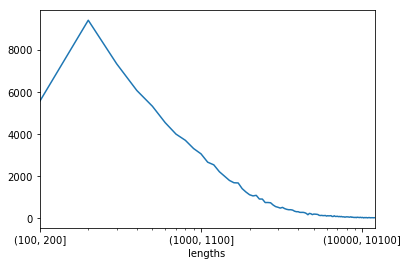

In [38]:
cuts = [i*100 for i in range(121)]
grouped_by_length = df.groupby(pd.cut(df.lengths, cuts)).count()

grouped_by_length['lengths'].describe()
grouped_by_length['lengths'].plot(logx=True)

To avoid truncating any strings, I'd have to pad all of them to a length of 119388.  However, most of the text samples are less than 1/10th that length, so padding to that length would be ridiculous.

I believe a better approach will be to split the text into substrings padded to 128 characters. This should be sufficiently long to contain multiple word breaks per sample while not taking too long to train on my poor abused laptop

In [18]:
# convert the data samples to a single list of words
all_text = " ".join(df['text'].values.tolist()).split()

In [19]:
def generate_samples(word_list, max_length=128):
    current_length = 0
    current_list = []
    for word in word_list:
        wl = len(word)
        
        if current_length + wl >= max_length:
            yield current_list
            current_length = 0
            current_list = []
            
        current_length += wl
        current_list.append(word)
        
# joining with space will make the strings longer than 128 characters
# but this is fine since they'll be removed later and I'll need them 
# to convert the samples to labels
samples = [' '.join(sample) for sample in generate_samples(all_text)]

In [42]:
print(samples[0])
print(f'Sample 0 length: {len(samples[0])}')
print(f'Total Samples: {len(samples)}')

นาโนเซนเซอร์,"นาโน เซนเซอร์ นาโน เซนเซอร์ เป็น เทคโนโลยี ที่ ใช้ ใน การ ตรวจ วัด ได้ ใน หลากหลาย รูปแบบ เช่น ตรวจ ของ สะสม ใน ร่างกาย ตรวจ แอลกอฮอล์ ใน
Sample 0 length: 151
Total Samples: 1131039


At this point, samples is a list containing strings slightly above 128 characters long.  The next step will remove the spaces and pad the strings to 128 characters exactly, but first, always save your data kids.

In [44]:
np.save(f'{base_url}/all_samples.npy', samples)

## Processing the samples

Since the purpose of this model will be to add spaces to thai text, I'll need to remove all the spaces from the training samples.

Afterwards, I'll pad all samples to the same length, convert each character to an integer encoding, then finally convert each integer to a 1-hot array

In [21]:
from keras.preprocessing.sequence import pad_sequences

if not os.path.isfile(f'{base_url}/train_X.npy'):
    def thai_text_to_vec(sample, char_to_int_dict, num_classes=None):
        """
        Accepts a string of thai text and converts it to an
        array of 1-hot vectors using map_dict to encode
        """
        if num_classes is None:
            num_classes = len(char_to_int_dict)

        int_seq = [char_to_int_dict[c] for c in sample] 

        return int_seq

    num_classes = len(char_to_int)
    inputs = [s.replace(' ', '') for s in samples]
    inputs = [thai_text_to_vec(s, char_to_int, num_classes) for s in inputs]

    input_padded = pad_sequences(inputs,
                                maxlen=128, padding='post', truncating='post')

    # saving the sequences for later
    np.save(os.path.join(base_url, 'train_X.npy'), input_padded[:-30000])
    # last 30000 examples for validation and testing
    np.save(os.path.join(base_url, 'validation_X.npy'), input_padded[-30000:-15000])
    np.save(os.path.join(base_url, 'test_X.npy'), input_padded[-15000:])

## Creating the labels

I'll need to create the target vectors from the input.  To indicate spaces, I'll convert each word to an array with a 1 indicating the word start and 0 otherwise

In [46]:
if not os.path.isfile(f'{base_url}/train_y.npy'):
# string replace all space+word start combos with 1s, all other with 0s
    def convert_samples_to_labels(samples):
        for sample in samples:
            label = np.zeros(128)
            tokens = sample.split(' ')
            idx = 0

            for token in tokens:
                label[idx] = 1
                idx += len(token)

            yield label

    label_gen = convert_samples_to_labels(samples)

    labels = [label for label in label_gen]

    print(''.join(labels[1000]))

    # save labels to disk for later
    np.save(os.path.join(base_url, 'train_y'), labels[:-30000])
    np.save(os.path.join(base_url, 'validation_y'), labels[-30000:-15000])
    np.save(os.path.join(base_url, 'test_y'), labels[-15000:])

In [55]:
example = labels[1000]
print(example.astype('int'))

[1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


And that's all for today.  Tomorrow I'll see whether this data setup will work well or not